In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
pd.options.display.float_format = '{:.3f}'.format 
np.set_printoptions(suppress=True, precision=5)

import warnings
warnings.filterwarnings("ignore")

In [37]:
#import
df = pd.read_csv(r'E:\learn st new\Credit score\loan_data_preprocess.csv', low_memory= False)
df.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,earliest_cr_yr,yr_since_last_inq,yrs_of_labour,loan_ending
0,1077501,5000,36,10.650,162.870,B,B2,RENT,24000.000,Verified,...,171.620,2016-01-01,0.000,1,INDIVIDUAL,0.000,1985.000,0.000,10,good
1,1077430,2500,60,15.270,59.830,C,C4,RENT,30000.000,Source Verified,...,119.660,2013-09-01,0.000,1,INDIVIDUAL,0.000,1999.000,3.000,0,bad
2,1077175,2400,36,15.960,84.330,C,C5,RENT,12252.000,Not Verified,...,649.910,2016-01-01,0.000,1,INDIVIDUAL,0.000,2001.000,0.000,10,good
3,1076863,10000,36,13.490,339.310,C,C1,RENT,49200.000,Source Verified,...,357.480,2015-01-01,0.000,1,INDIVIDUAL,0.000,1996.000,1.000,10,good
4,1075269,5000,36,7.900,156.460,A,A4,RENT,36000.000,Source Verified,...,161.030,2015-09-01,0.000,1,INDIVIDUAL,0.000,2004.000,1.000,3,good


In [38]:
# nhóm các biến đầu vào và đầu ra thành các dataframe
input = df.drop(columns = ['policy_code', 'application_type'])
output = df['loan_ending']

## THỐNG KÊ MÔ TẢ
---

In [39]:
# Nhóm các biến định tính
cat_col = []
for x in input.dtypes.index:
    if input.dtypes[x] == 'object':
        cat_col.append(x)

cat_col

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'loan_ending']

In [40]:
# Nhóm các biến định lượng
num_col = []
for x in input.dtypes.index:
    if input.dtypes[x] != 'object':
        num_col.append(x)

num_col

['id',
 'loan_amnt',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'earliest_cr_yr',
 'yr_since_last_inq',
 'yrs_of_labour']

In [41]:
#biểu đồ mô tả các biến nhân khẩu
demographic = ['grade','sub_grade','home_ownership','initial_list_status','purpose','yrs_of_labour','acc_now_delinq','term','open_acc']

def risk_pct_chart(x):
     ratio = (df.groupby(x)['loan_ending'] 
         .value_counts(normalize=True)
         .mul(100)
         .rename('count')
         .reset_index())

     plt.figure(figsize =(12,5))
     sns.lineplot(data =ratio[ratio['loan_ending'] == 'bad'], x= x, y='count')
     plt.title(x)
     plt.show()

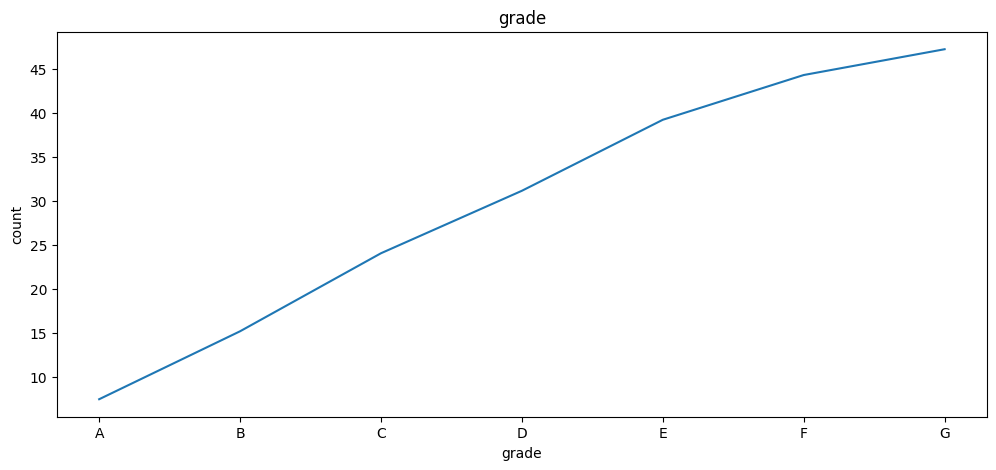

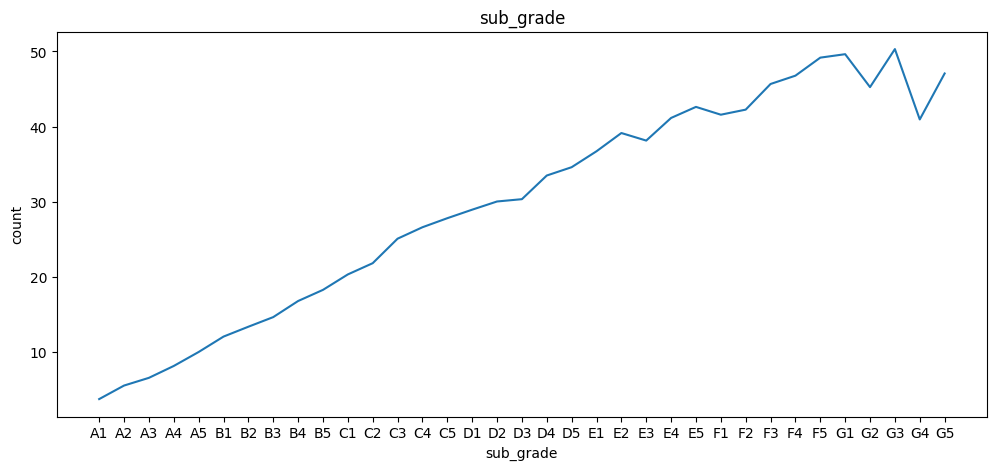

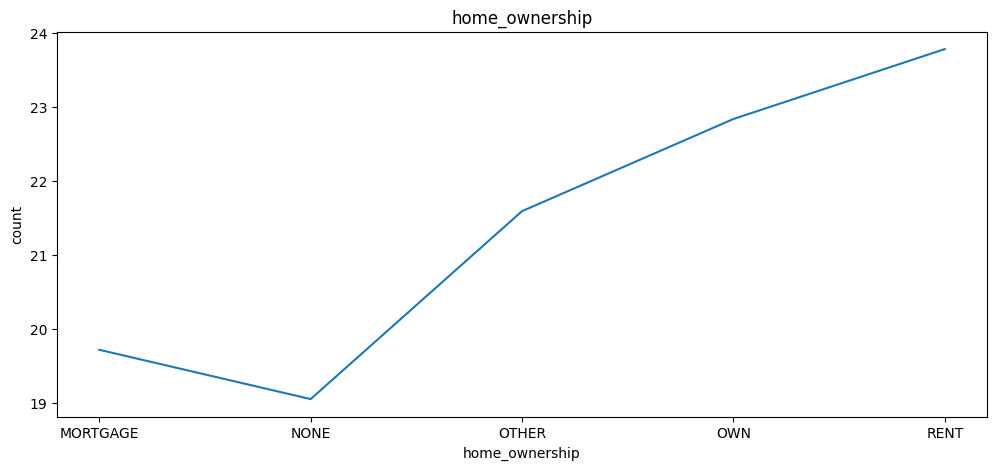

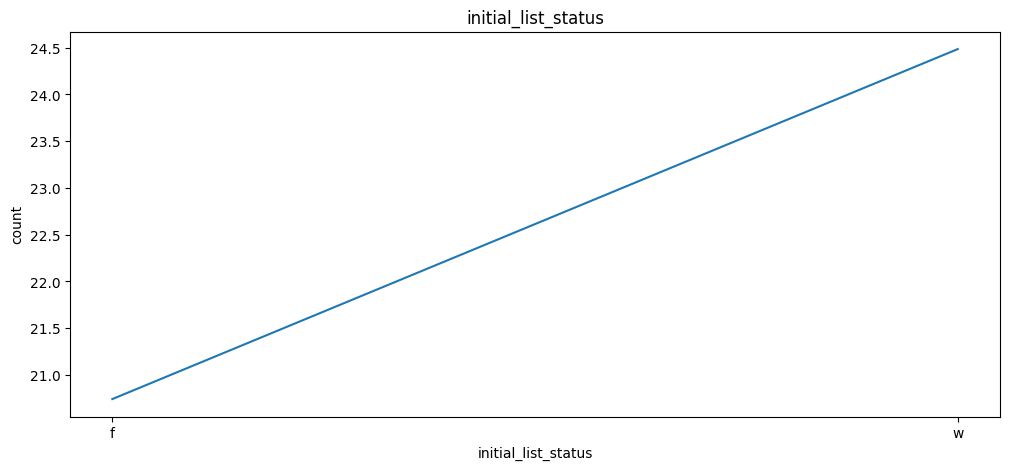

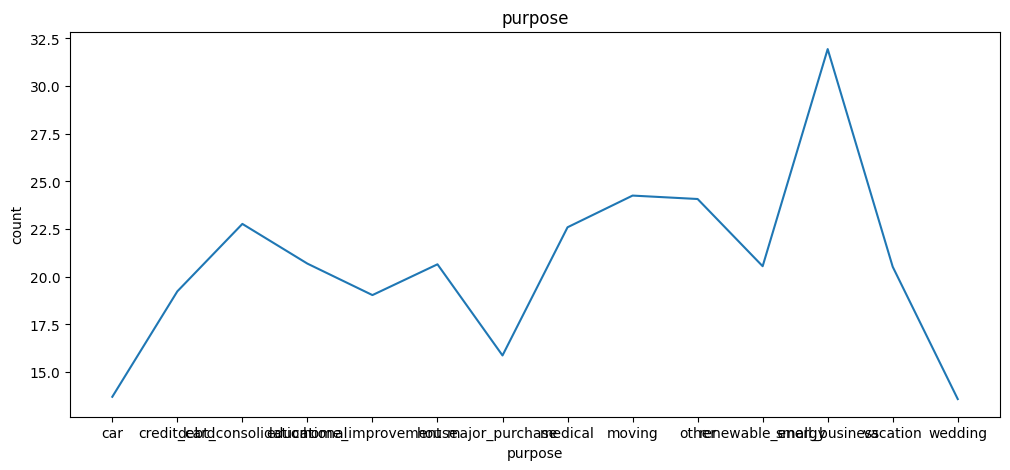

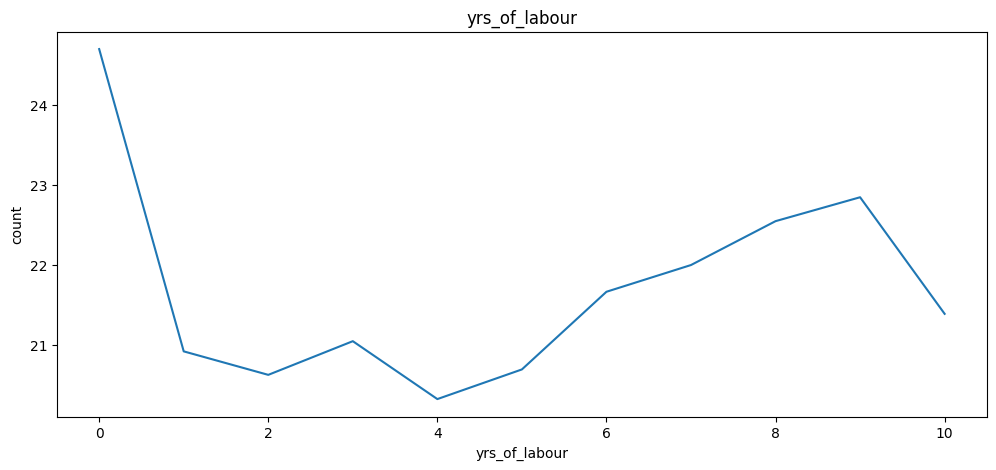

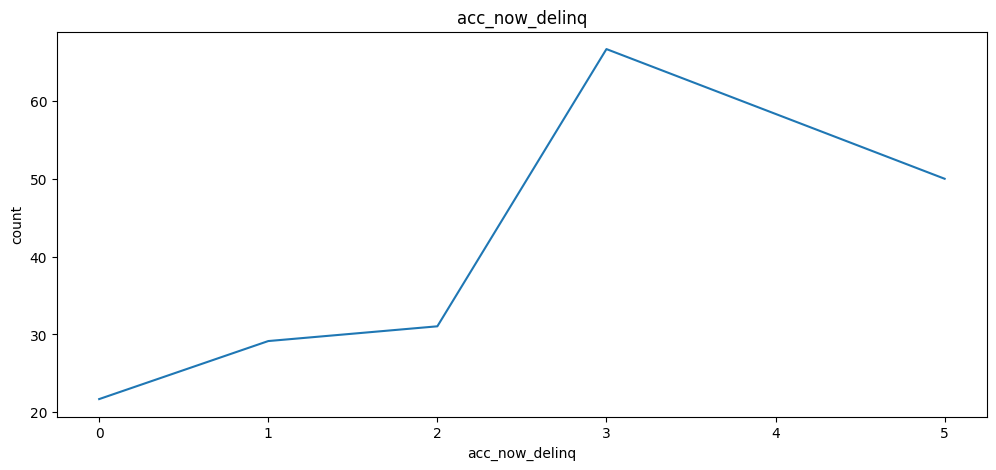

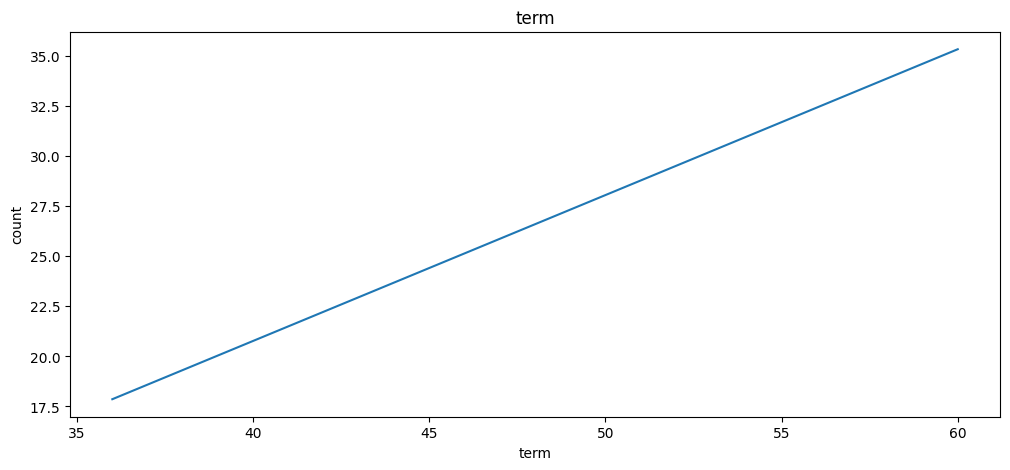

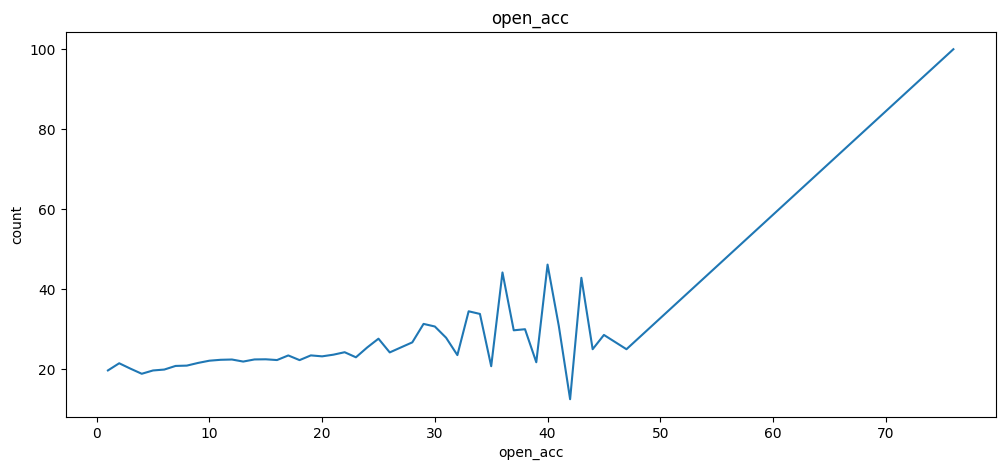

In [7]:
for cols in demographic:
    risk_pct_chart(cols)

### Nhận xét:
<li> Có sự thay đổi rõ ràng đối với nhóm term, initial list status và grade/sub_grade
<li> Đối với các nhóm nhân khẩu còn lại, sự khác biệt nằm ở trong những nhóm nhất định và sự chênh lệch là khác nhau giữa các nhóm trong cùng một biến
<li> Trong nhóm home_ownership, phân nhóm other, none, any có số lượng khá nhỏ vì vậy có thể đưa vào cùng nhóm với RENT

In [42]:
input['home_ownership'] = input['home_ownership'].replace('OTHER','RENT')
input['home_ownership'] = input['home_ownership'].replace('NONE','RENT')
input['home_ownership'] = input['home_ownership'].replace('ANY','RENT')

<Axes: >

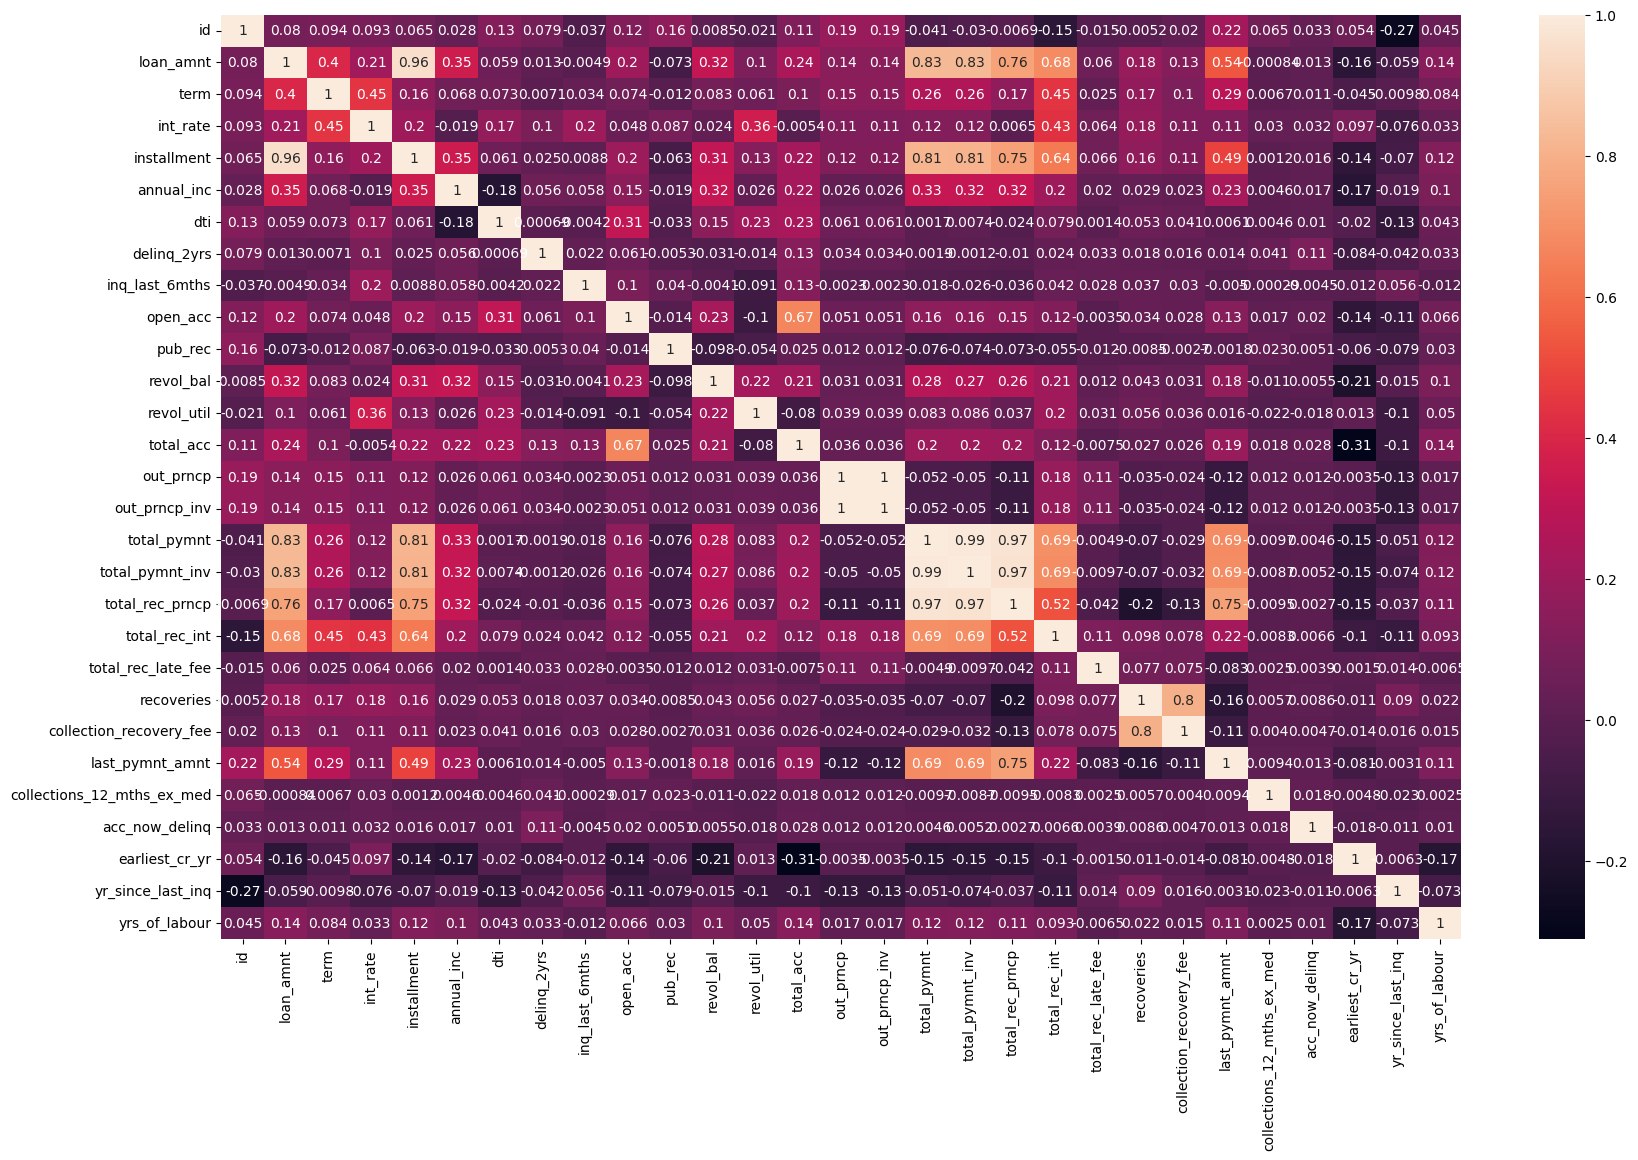

In [9]:
#Biểu đồ ma trận tương quan

plt.figure(figsize=(20,12))
sns.heatmap(data= input[num_col].corr(), annot = True)

### Nhận xét:
<li> Những biến có hệ số tương quan càng lớn, đồng nghĩa các biến đó có thể thay thế cho nhau, vì vậy nên loại bỏ 1 trong 2 biến có tương quan cao
<li> Loan_amnt có tương quan cao với installment, total_pymnt,  total_pymnt_inv, total_rec_prncp, . Cần loại các biến này.
<li> last_pymnt_amnt cũng có tương quan cao với loan_amnt và installment cũng như đa số các biến khác ở nhóm 2. Tuy nhiên, xem xét tới ý nghĩa của biến này, vẫn giữ lại trong mô hình
<li> recoveries và colloection_recovery_fee có tương quan cao = 0.8 nên loại 1 trong 2 biến này.
<li> total_acc và open_acc cũng có tương quan cao =0.67 nên loại 1 trong 2 biến này.
<li> out_prncp và out_prncp_inv có tương quan = 1 --> loại 1 trong 2 biến này

In [43]:
# Drop các columns có correlation cao
input = input.drop(columns = ['installment', 'total_pymnt','total_pymnt_inv','total_rec_prncp'
                              ,'out_prncp_inv', 'collection_recovery_fee','total_acc','sub_grade'])

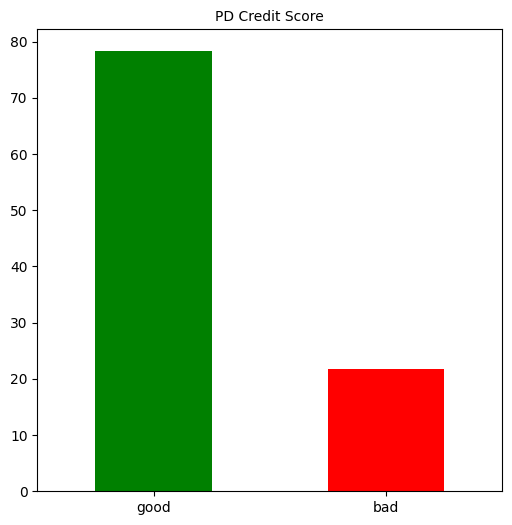

In [44]:
default_count = (output.value_counts(normalize=True)*100)
default_count.plot.bar(figsize=(6,6), color =['g','r'])
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.title("PD Credit Score", fontsize=10)
plt.show()

### Nhận xét: 
- Số lượng tín dụng tốt và xấu có sự mất cân bằng lớn

## Binning, Weight of Evidence (WoE), Information Value (IV)
---
Bining nhằm phân tổ các dữ liệu thành dạng category
<li>Sử dụng WoE nhằm lựa chọn các loại thành phần nên được nhóm
<li>Sử dụng IV nhằm chọn ra các features tốt nhất cho PD model

In [45]:
outpt = []
for i in range(0, len(output)):
    if output[i] == 'good':
        outpt.append(1)
    else:
        outpt.append(0)
outpt = pd.DataFrame(outpt, columns = ['loan_crt_score'])

In [46]:
# Tính WoE và IV cho biến định danh nominal

def woe_discrete(df,independent_variable,dependent_variable):
    df = pd.concat([df[independent_variable],dependent_variable],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),
    df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
    df = df.iloc[:,[0,1,3]]
    
    df.columns = [df.columns.values[0],'n_obs','prop_good']
    df['no_good'] = df['prop_good'] * df['n_obs']
    df['no_bad'] = (1- df['prop_good']) * df['n_obs']
    df['Final_good'] = df['no_good']/df['no_good'].sum()
    df['Final_bad'] = df['no_bad']/df['no_bad'].sum()
    df['WOE'] = np.log(df['Final_good']/df['Final_bad'])

    
    df = df.sort_values(['WOE'])
    df = df.reset_index(drop=True)
    df['IV'] = (df['Final_good']-df['Final_bad']) * df['WOE']
    df['IV_total'] = df['IV'].sum()
    print('===================== Information value of ' +independent_variable+' is '+ str(round(df['IV'].sum(),3))+' ===================')
    return df


In [47]:
# Vẽ plot
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WOE']
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, marker = 'o', color = 'hotpink', linestyle = 'dashed', linewidth = 3, markersize = 18, markeredgecolor = 'cyan', markerfacecolor = 'black')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels) 
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

In [48]:
# Nhóm các biến định danh
norminal_var = ['term', 'grade','home_ownership', 'verification_status',
                'pymnt_plan', 'purpose', 'yrs_of_labour', 'yr_since_last_inq','initial_list_status']

for i in range(0, len(norminal_var)):
    print(woe_discrete(input,norminal_var[i],outpt))

===================== Information value of term is 0.163 ===================
   term   n_obs  prop_good    no_good    no_bad  Final_good  Final_bad    WOE  \
0    60   52197      0.647  33748.000 18449.000       0.181      0.358 -0.679   
1    36  185463      0.821 152336.000 33127.000       0.819      0.642  0.243   

     IV  IV_total  
0 0.120     0.163  
1 0.043     0.163  
===================== Information value of grade is 0.396 ===================
  grade  n_obs  prop_good   no_good    no_bad  Final_good  Final_bad    WOE  \
0     G   1960      0.528  1034.000   926.000       0.006      0.018 -1.173   
1     F   7292      0.557  4061.000  3231.000       0.022      0.063 -1.055   
2     E  17926      0.608 10896.000  7030.000       0.059      0.136 -0.845   
3     D  38452      0.689 26479.000 11973.000       0.142      0.232 -0.489   
4     C  60757      0.760 46158.000 14599.000       0.248      0.283 -0.132   
5     B  71956      0.849 61055.000 10901.000       0.328      0.21

### Nhận xét
Dựa vào điều kiện IV <0.02 và >0.5 sẽ không có ý nghĩa cho mô hình dự báo, ta loại initial_list_status, yrs_of_labour, pymnt_plan, home_ownership

In [49]:
#loại các biến vừa đề cập
input = input.drop(columns = ['home_ownership','initial_list_status','yrs_of_labour','pymnt_plan'])

In [50]:
#months since last issue
input['issue_d'] = pd.to_datetime(input['issue_d'], format ="%Y-%m-%d")
df1 = pd.to_datetime('2016-12-31') - input['issue_d']
input['mths_since_issue'] = round(pd.to_numeric(df1/np.timedelta64(1,'M')))


# months since last credit_pull_day
df2 = pd.to_datetime('2016-12-31') - pd.to_datetime(input['last_credit_pull_d'], format ="%Y-%m-%d")
input['mths_since_last_crt_pull_day'] = round(pd.to_numeric(df2/np.timedelta64(1,'M')))


#month since last pymnt_day
df3 = pd.to_datetime('2016-12-31') - pd.to_datetime(input['last_pymnt_d'], format ="%Y-%m-%d")
input['mths_since_last_pymnt_day'] = round(pd.to_numeric(df3/np.timedelta64(1,'M')))

Sau khi xử lý các dữ liệu ngày tháng, bỏ đi các cột chứa ngày tháng để lọc đầu vào cho mô hình

In [51]:
#Sau khi xử lý các dữ liệu ngày tháng, bỏ đi các cột chứa ngày tháng để lọc đầu vào cho mô hình
input = input.drop(columns = ['issue_d','last_credit_pull_d','last_pymnt_d'])

In [52]:
input[['inq_last_6mths','pub_rec', 'out_prncp','int_rate','total_rec_int']].describe()

,inq_last_6mths,pub_rec,out_prncp,int_rate,total_rec_int
count,237660.000,237660.000,237660.000,237660.000,237660.000
mean,0.906,0.135,375.794,13.853,2136.468
std,1.171,0.421,2331.587,4.380,2163.234
min,0.000,0.000,0.000,5.420,0.000
25%,0.000,0.000,0.000,10.990,750.277
50%,1.000,0.000,0.000,13.670,1471.500
75%,1.000,0.000,0.000,16.590,2710.895
max,33.000,11.000,32160.380,26.060,22777.580


<Axes: xlabel='out_prncp', ylabel='Density'>

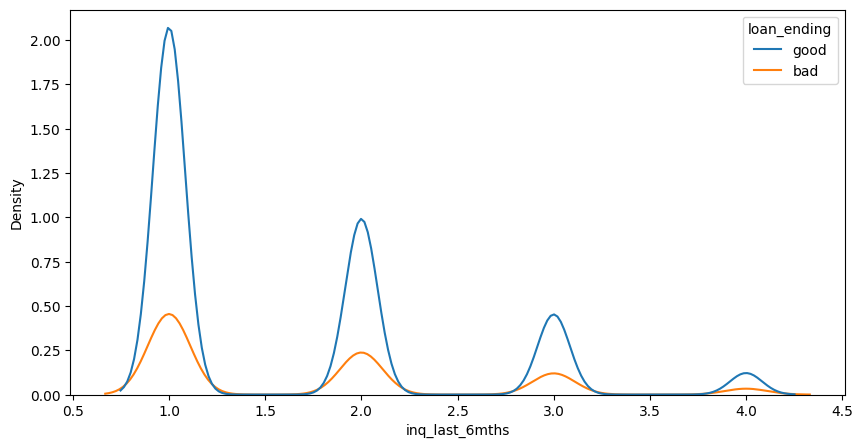

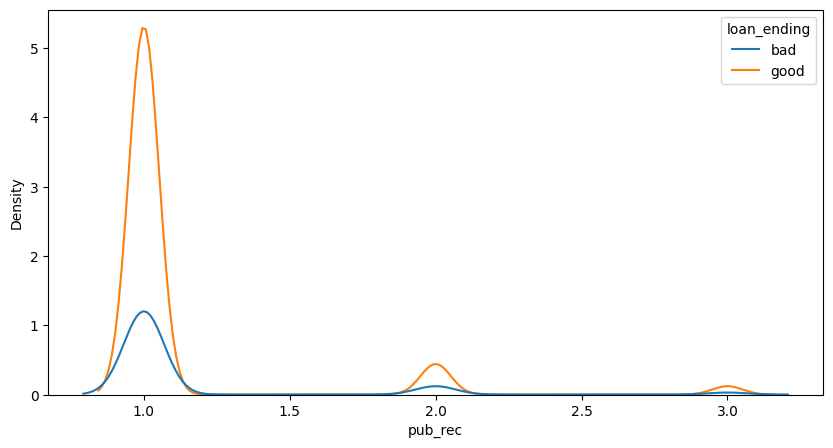

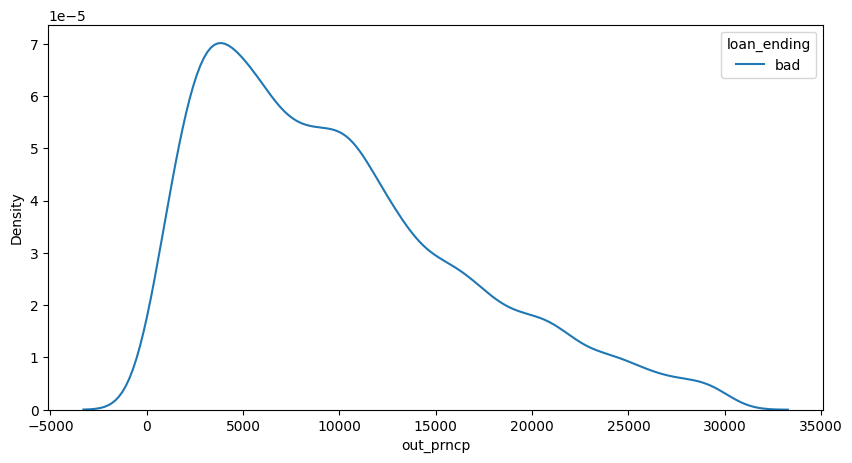

In [53]:
plt.figure(figsize = (10,5))
sns.kdeplot(data = input[(input['inq_last_6mths']< 5) &(input['inq_last_6mths'] >0) ], x ='inq_last_6mths', hue ='loan_ending')

plt.figure(figsize = (10,5))
sns.kdeplot(data = input[(input['pub_rec']<4) &(input['pub_rec'] >0) ], x ='pub_rec', hue ='loan_ending')

plt.figure(figsize = (10,5))
sns.kdeplot(data = input[(input['out_prncp']<30000) &(input['out_prncp'] >0) ], x ='out_prncp', hue ='loan_ending')


In [54]:
input = input.drop(columns = ['pub_rec','inq_last_6mths'])

### Nhận xét:
- 2 biến inq_last_month, pub_rec có phân phối khá tương đồng giữa 2 nhóm đầu ra vì vậy khó để phân loại tốt xấu giữa các đầu ra
- Biến còn lại có 100% xấu nên vẫn có thể giữ lại

In [55]:
input = input.drop(columns ='earliest_cr_line')

In [56]:
outpt = []
for i in range(0, len(output)):
    if input['loan_ending'][i] == 'good':
        outpt.append(1)
    else:
        outpt.append(0)
outpt = pd.DataFrame(outpt, columns = ['loan_crt_score'])

In [57]:
input2 =input.copy()

In [58]:
#Tạo hàm tính IV và WoE cho biến có dữ liệu liên tục

def woe_discrete(df,independent_variable,dependent_variable):
    df = pd.concat([df[independent_variable],dependent_variable],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),
    df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
    df = df.iloc[:,[0,1,3]]
    
    df.columns = [df.columns.values[0],'n_obs','prop_good']
    df['no_good'] = df['prop_good'] * df['n_obs']
    df['no_bad'] = (1- df['prop_good']) * df['n_obs']
    df['Final_good'] = df['no_good']/df['no_good'].sum()
    df['Final_bad'] = df['no_bad']/df['no_bad'].sum()
    df['WOE'] = np.log(df['Final_good']/df['Final_bad'])

    df = df.sort_values(independent_variable) ## chỗ khác
    df = df.reset_index(drop=True)
    df['IV'] = (df['Final_good']-df['Final_bad']) * df['WOE']
    df['IV_total'] = df['IV'].sum()
    print('===================== Information value of ' +independent_variable+' is '+ str(round(df['IV'].sum(),3))+' ===================')
    return df

In [59]:
input['loan_amnt'] = pd.cut(input['loan_amnt'],10)
input['annual_inc']= pd.cut(input['annual_inc'], 4)
input['dti'] = pd.cut(input['dti'],10)
input['acc_now_delinq'] = pd.cut(input['acc_now_delinq'], 3)
input['earliest_cr_yr'] = pd.cut(input['earliest_cr_yr'], 10)
input['mths_since_issue'] = pd.cut(input['mths_since_issue'], 10)
input['mths_since_last_crt_pull_day'] = pd.cut(input['mths_since_last_crt_pull_day'], 10)
input['mths_since_last_pymnt_day'] = pd.cut(input['mths_since_last_pymnt_day'], 10)
input['open_acc'] = pd.cut(input['open_acc'] ,5)
input['delinq_2yrs'] = pd.cut(input['delinq_2yrs'], 3)
input['revol_bal'] =pd.cut(input['revol_bal'], 10)
input['revol_util'] =pd.cut(input['revol_util'], 10)
input['int_rate'] = pd.cut(input['int_rate'], 10)
input['out_prncp'] =pd.cut(input['out_prncp'], 10)
# input['out_prncp_inv'] = pd.cut(input['out_prncp_inv'],10)
input['recoveries'] = pd.cut(input['recoveries'], 10)
input['last_pymnt_amnt'] = pd.cut(input['last_pymnt_amnt'], 10)
input['collections_12_mths_ex_med']= pd.cut(input['collections_12_mths_ex_med'], 3)
input['total_rec_int']= pd.cut(input['total_rec_int'], 10)
input['total_rec_late_fee']= pd.cut(input['total_rec_late_fee'], 10)


In [60]:
# Tính WoE
print(woe_discrete(input, 'loan_amnt', outpt))

print(woe_discrete(input, 'annual_inc', outpt))

print(woe_discrete(input, 'dti', outpt))

print(woe_discrete(input, 'acc_now_delinq', outpt))

print(woe_discrete(input, 'earliest_cr_yr', outpt))

print(woe_discrete(input, 'mths_since_issue', outpt))

print(woe_discrete(input, 'mths_since_last_crt_pull_day', outpt))

print(woe_discrete(input, 'mths_since_last_pymnt_day', outpt))

print(woe_discrete(input, 'open_acc', outpt))

print(woe_discrete(input, 'delinq_2yrs', outpt))

print(woe_discrete(input, 'revol_bal', outpt))

print(woe_discrete(input, 'revol_util', outpt))

print(woe_discrete(input, 'int_rate', outpt))

print(woe_discrete(input, 'out_prncp', outpt))

print(woe_discrete(input, 'recoveries', outpt))

print(woe_discrete(input, 'last_pymnt_amnt', outpt))

print(woe_discrete(input, 'collections_12_mths_ex_med', outpt))

print(woe_discrete(input, 'total_rec_int', outpt))

print(woe_discrete(input, 'total_rec_late_fee', outpt))


===================== Information value of loan_amnt is 0.034 ===================
            loan_amnt  n_obs  prop_good   no_good    no_bad  Final_good  \
0     (465.5, 3950.0]  16818      0.828 13922.000  2896.000       0.075   
1    (3950.0, 7400.0]  43189      0.818 35308.000  7881.000       0.190   
2   (7400.0, 10850.0]  49523      0.796 39400.000 10123.000       0.212   
3  (10850.0, 14300.0]  33629      0.793 26669.000  6960.000       0.143   
4  (14300.0, 17750.0]  29475      0.766 22573.000  6902.000       0.121   
5  (17750.0, 21200.0]  27257      0.760 20708.000  6549.000       0.111   
6  (21200.0, 24650.0]  11282      0.740  8351.000  2931.000       0.045   
7  (24650.0, 28100.0]  11565      0.737  8523.000  3042.000       0.046   
8  (28100.0, 31550.0]   5762      0.704  4054.000  1708.000       0.022   
9  (31550.0, 35000.0]   9160      0.718  6576.000  2584.000       0.035   

   Final_bad    WOE    IV  IV_total  
0      0.056  0.287 0.005     0.034  
1      0.153  0.

- Khi xem xét các feature, nhóm recoveries, total_rec_late_fee và last_pymnt_amnt có những bin chứa 100% số lượng được phân ra nhóm tốt/ xấu, vì vậy vẫn giữ lại 2 biến này dù IV > 0.5
- out_prncp vẫn có thể giữ lại và chia ra làm 2 nhóm 
    <ul><li>(-32.16, 3216.038]
    <li>(3216.038,32160.38]</ul>\
- Đối với các biến còn lại, vẫn tuân theo tiêu chuẩn để loại biến: IV > 0.5 và IV< 0.02


In [61]:
#Bỏ  delinq_2yrs, mths_since_last_pymnt_day, open_acc, yr_since_last_inq, annual_inc earliest_cr_yr acc_now_delinq 

input = input.drop(columns = ['delinq_2yrs', 'mths_since_last_pymnt_day','mths_since_last_crt_pull_day','earliest_cr_yr','acc_now_delinq',
                              'open_acc', 'annual_inc','addr_state','id','revol_bal','revol_util','collections_12_mths_ex_med'])

===================== Information value of loan_amnt is 0.034 ===================


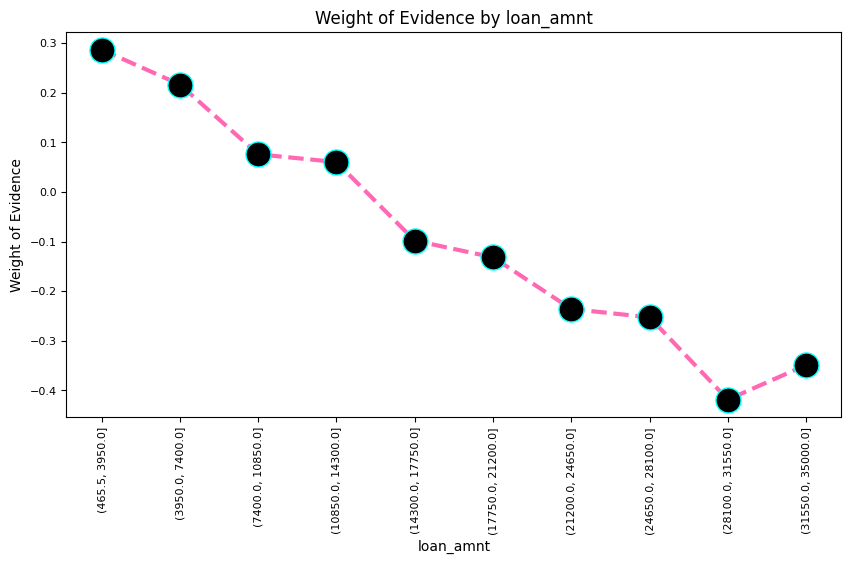

None
===================== Information value of dti is 0.096 ===================


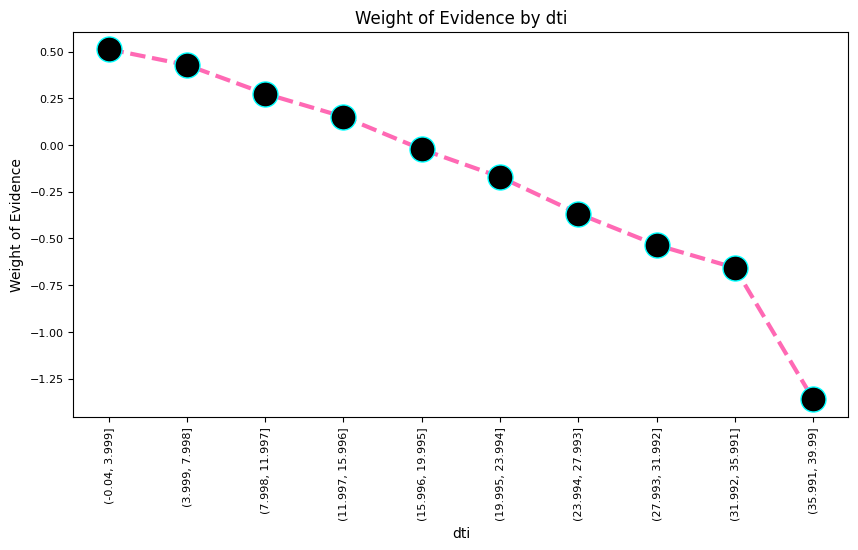

None
===================== Information value of mths_since_issue is 0.072 ===================


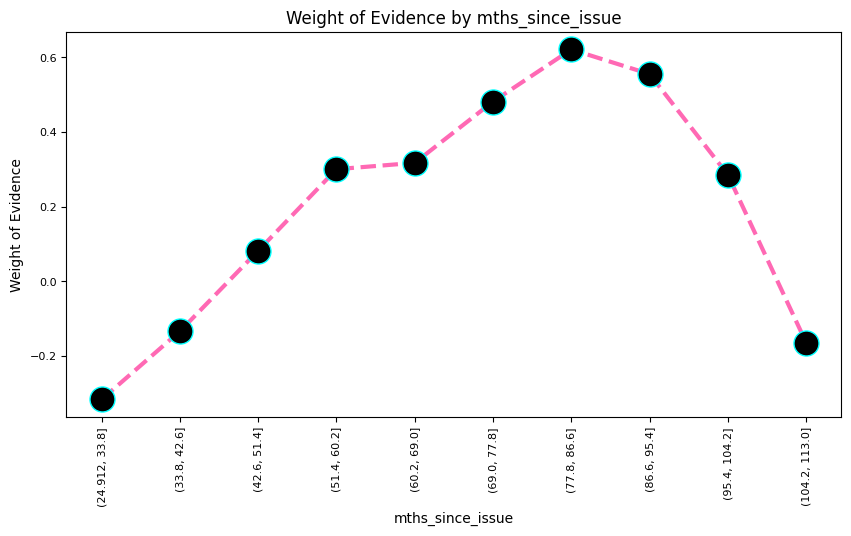

None
===================== Information value of int_rate is 0.408 ===================


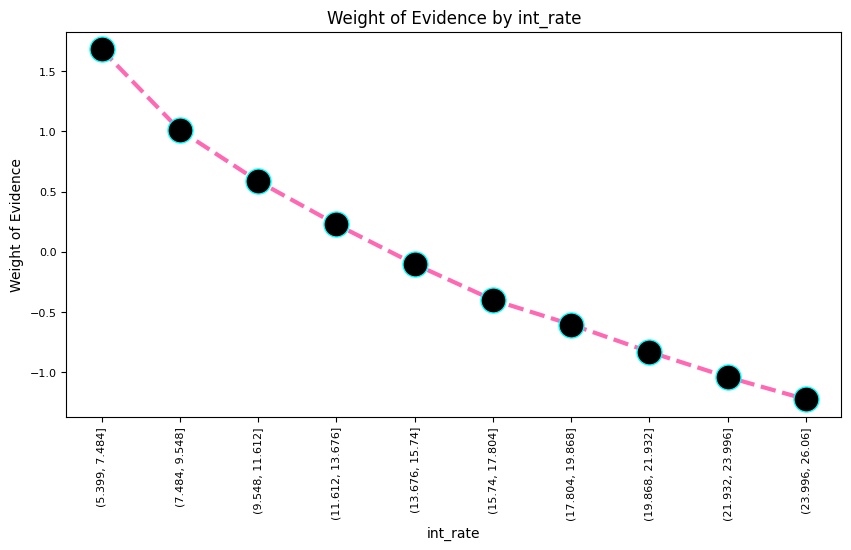

None
===================== Information value of out_prncp is inf ===================


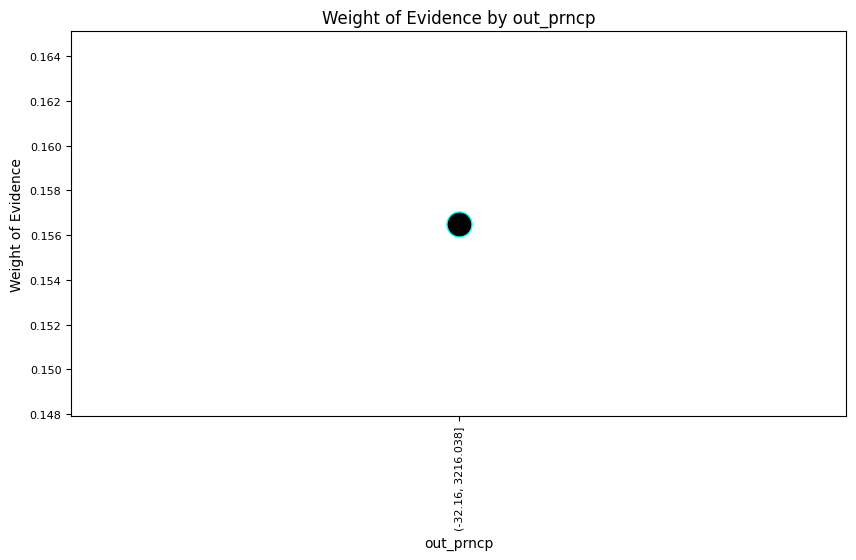

None
===================== Information value of recoveries is inf ===================


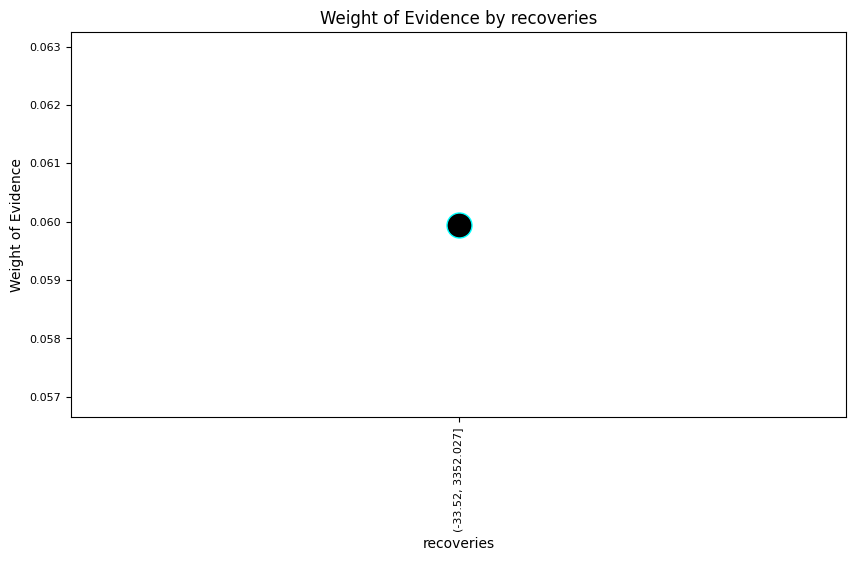

None
===================== Information value of last_pymnt_amnt is inf ===================


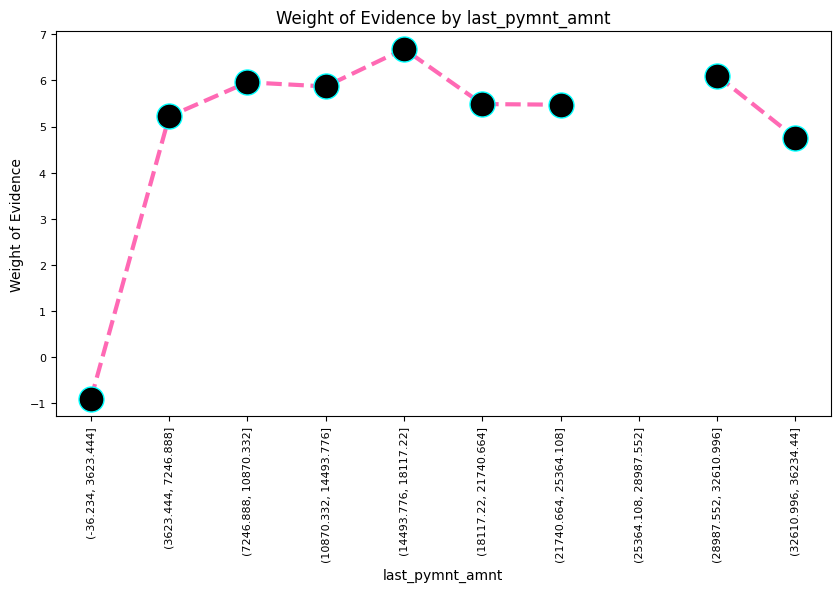

None
===================== Information value of total_rec_int is 0.03 ===================


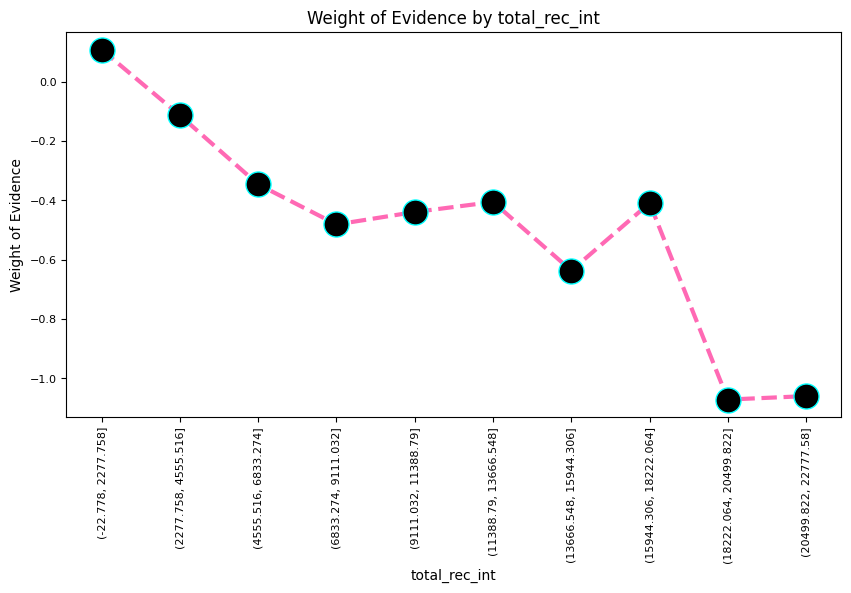

None
===================== Information value of total_rec_late_fee is inf ===================


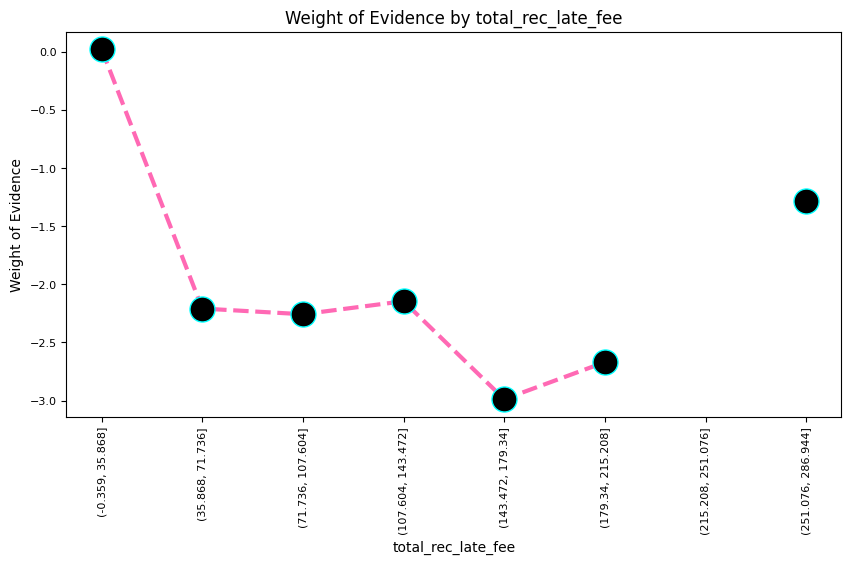

None


In [63]:
# Visual các feature được giữ lại
continuous_var = ['loan_amnt','dti','mths_since_issue','int_rate','out_prncp',
                  'recoveries','last_pymnt_amnt','total_rec_int','total_rec_late_fee']

for i in range(0, len(continuous_var)):
    print(plot_by_woe(woe_discrete(input, continuous_var[i], outpt), 90))

### BIẾN LIÊN TỤC
Phân phối lại các bins theo WoE:
- loan_amnt: 0, 1 ,(2,3), (4,5), (6,7), 8, 9 
- mths_since_issue: 0,1,2, (3,4), 5,6,7,8,9
- total_rec_int: 0,1, (2,3,4,5) ,6,7, (8,9) 
- total_rec_late_fee: nhóm bins (1,2,3), (4,5), (6-9) 
- last_pymnt_amnt : (1,2,3,4,5,6), (7-9)
- recoveries: nên loại khỏi mô hình

In [64]:
preprocess = pd.get_dummies(input)
preprocess2 = pd.get_dummies(preprocess['term'])
preprocess3 = pd.get_dummies(preprocess['yr_since_last_inq'])

## Tạo feature mới dựa trên WoE và dummies

In [65]:
# Grade
new_input = preprocess.loc[:, ['grade_A','grade_B','grade_D','grade_E','grade_G']]

# term
new_input['term_60'] = preprocess2.loc[:, 60]

#verification_status
new_input['verification_status_Verified'] = preprocess.loc[:, 'verification_status_Verified']
new_input['verification_status_Not Verified'] = preprocess.loc[:, 'verification_status_Not Verified']

#purpose
new_input['purpose_small_business'] =  preprocess.loc[:, 'purpose_small_business']
new_input['purpose_debt_medical'] = sum([preprocess['purpose_debt_consolidation'], preprocess['purpose_medical']])
new_input['purpose_moving_other'] = sum([preprocess['purpose_moving'], preprocess['purpose_other']])
new_input['purpose_educational_house_energy_vacation'] = sum([preprocess['purpose_educational'], preprocess['purpose_house'],
                                                              preprocess['purpose_renewable_energy'], preprocess['purpose_vacation']])
new_input['purpose_credit_homeimprovement'] = sum([preprocess['purpose_credit_card'], preprocess['purpose_home_improvement']])
new_input['purpose_car_wedding'] = sum([preprocess['purpose_car'], preprocess['purpose_wedding']])

#yrs_since_last_inq
new_input['yr_since_last_inq_7'] = preprocess3.loc[:, 7.000]
new_input['yr_since_last_inq_0'] = preprocess3.loc[:, 0.000]
new_input['yr_since_last_inq_4_5_6'] = sum([preprocess3[4.000], preprocess3[5.000], preprocess3[6.000]])
new_input['yr_since_last_inq_7'] = preprocess3.loc[:, 7.000]
new_input['yr_since_last_inq_8'] =preprocess3.loc[:, 8.000]
new_input['yr_since_last_inq_9'] =preprocess3.loc[:, 9.000]

#loan_amnt
new_input['loan_amnt_(465.5, 7400.0]'] = sum([preprocess['loan_amnt_(465.5, 3950.0]'], preprocess['loan_amnt_(3950.0, 7400.0]']])
new_input['loan_amnt_(14300.0, 21200.0]'] = sum([preprocess['loan_amnt_(14300.0, 17750.0]'], preprocess['loan_amnt_(17750.0, 21200.0]']])
new_input['loan_amnt_(21200.0, 28100.0]'] = sum([preprocess['loan_amnt_(21200.0, 24650.0]'], preprocess['loan_amnt_(24650.0, 28100.0]']])
new_input['loan_amnt_(21200.0, 28100.0]'] = sum([preprocess['loan_amnt_(21200.0, 24650.0]'], preprocess['loan_amnt_(24650.0, 28100.0]']])
new_input['loan_amnt_(28100.0, 35000.0]'] = sum([preprocess['loan_amnt_(28100.0, 31550.0]'], preprocess['loan_amnt_(31550.0, 35000.0]']])

#dti
new_input['dti_(-0.04, 3.999]'] = preprocess.loc[:, 'dti_(-0.04, 3.999]']
new_input['dti_(3.999, 7.998]'] = preprocess.loc[:, 'dti_(3.999, 7.998]']
new_input['dti_(7.998, 11.997]'] = preprocess.loc[:, 'dti_(7.998, 11.997]']
new_input['dti_(11.997, 15.996]'] = preprocess.loc[:, 'dti_(11.997, 15.996]']
new_input['dti_(19.995, 23.994]'] = preprocess.loc[:, 'dti_(19.995, 23.994]']
new_input['dti_(23.994, 27.993]'] = preprocess.loc[:, 'dti_(23.994, 27.993]']
new_input['dti_(31.992, 35.991]'] = preprocess.loc[:, 'dti_(31.992, 35.991]']
new_input['dti_(35.991, 39.99]'] = preprocess.loc[:, 'dti_(35.991, 39.99]']

#mths_since_issue
new_input['mths_since_issue_(24.912, 33.8]'] = preprocess.loc[:, 'mths_since_issue_(24.912, 33.8]']
new_input['mths_since_issue_(24.912, 33.8]'] = preprocess.loc[:, 'mths_since_issue_(24.912, 33.8]']
new_input['mths_since_issue_(51.4, 69.0]'] = sum([preprocess['mths_since_issue_(51.4, 60.2]'], preprocess['mths_since_issue_(60.2, 69.0]']])
new_input['mths_since_issue_(69.0, 77.8]'] = preprocess.loc[:, 'mths_since_issue_(69.0, 77.8]']
new_input['mths_since_issue_(77.8, 86.6]'] = preprocess.loc[:, 'mths_since_issue_(77.8, 86.6]']
new_input['mths_since_issue_(86.6, 95.4]'] = preprocess.loc[:, 'mths_since_issue_(86.6, 95.4]']
new_input['mths_since_issue_(95.4, 104.2]'] = preprocess.loc[:, 'mths_since_issue_(95.4, 104.2]']
new_input['mths_since_issue_(104.2, 113.0]'] = preprocess.loc[:, 'mths_since_issue_(104.2, 113.0]']

#int_rate
new_input['int_rate_(5.399, 7.484]'] = preprocess.loc[:, 'int_rate_(5.399, 7.484]']
new_input['int_rate_(7.484, 9.548]'] = preprocess.loc[:, 'int_rate_(7.484, 9.548]']
new_input['int_rate_(9.548, 11.612]'] = preprocess.loc[:, 'int_rate_(9.548, 11.612]']
new_input['int_rate_(11.612, 13.676]'] = preprocess.loc[:, 'int_rate_(11.612, 13.676]']
new_input['int_rate_(15.74, 17.804]'] = preprocess.loc[:, 'int_rate_(15.74, 17.804]']
new_input['int_rate_(17.804, 19.868]'] = preprocess.loc[:, 'int_rate_(17.804, 19.868]']
new_input['int_rate_(19.868, 21.932]'] = preprocess.loc[:, 'int_rate_(19.868, 21.932]']
new_input['int_rate_(21.932, 23.996]'] = preprocess.loc[:, 'int_rate_(21.932, 23.996]']
new_input['int_rate_(23.996, 26.06]'] = preprocess.loc[:, 'int_rate_(23.996, 26.06]']

#out_prncp
new_input['out_prncp'] = input2.loc[:, 'out_prncp']

# last_pymnt_amnt
new_input['last_pymnt_amnt_(-36.234, 3623.444]'] = preprocess.loc[:,'last_pymnt_amnt_(-36.234, 3623.444]']
new_input['last_pymnt_amnt_(7246.888, 14493.776]'] = sum([preprocess['last_pymnt_amnt_(7246.888, 10870.332]'], preprocess['last_pymnt_amnt_(10870.332, 14493.776]']])
new_input['last_pymnt_amnt_(14493.776, 18117.22]'] = preprocess.loc[:,'last_pymnt_amnt_(14493.776, 18117.22]']
new_input['last_pymnt_amnt_(18117.22, 28987.552]'] = sum([preprocess['last_pymnt_amnt_(18117.22, 21740.664]'], 
                                                          preprocess['last_pymnt_amnt_(21740.664, 25364.108]'],preprocess['last_pymnt_amnt_(25364.108, 28987.552]']])
new_input['last_pymnt_amnt_(28987.552, 32610.996]'] = preprocess.loc[:,'last_pymnt_amnt_(28987.552, 32610.996]']
new_input['last_pymnt_amnt_(32610.996, 36234.44]'] = preprocess.loc[:,'last_pymnt_amnt_(32610.996, 36234.44]']

#total_rec_int: 0,1, (2,3,4,5) ,6,7, (8,9) 
new_input['total_rec_int_(-22.778, 2277.758]'] = preprocess.loc[:,'total_rec_int_(-22.778, 2277.758]']
new_input['total_rec_int_(2277.758, 4555.516]'] = preprocess.loc[:,'total_rec_int_(2277.758, 4555.516]']
new_input['total_rec_int_(4555.516, 13666.548]'] = sum([preprocess['total_rec_int_(4555.516, 6833.274]'],
                                                        preprocess['total_rec_int_(6833.274, 9111.032]'], preprocess['total_rec_int_(9111.032, 11388.79]']])
new_input['total_rec_int_(15944.306, 18222.064]'] = preprocess.loc[:,'total_rec_int_(15944.306, 18222.064]']
new_input['total_rec_int_(13666.548, 15944.306]'] = preprocess.loc[:,'total_rec_int_(13666.548, 15944.306]']
new_input['total_rec_int_(18222.064, 22777.58]'] = sum([preprocess['total_rec_int_(18222.064, 20499.822]'],preprocess['total_rec_int_(20499.822, 22777.58]']])

#total_rec_late_fee
new_input['total_rec_late_fee_(-0.359, 35.868]'] = preprocess.loc[:, 'total_rec_late_fee_(-0.359, 35.868]']
new_input['total_rec_late_fee_(35.868, 143.472]'] = sum([preprocess['total_rec_late_fee_(35.868, 71.736]'], 
                                                         preprocess['total_rec_late_fee_(71.736, 107.604]'], preprocess['total_rec_late_fee_(107.604, 143.472]']])
new_input['total_rec_late_fee_(143.472, 215.208]'] = sum([preprocess['total_rec_late_fee_(143.472, 179.34]'], preprocess['total_rec_late_fee_(179.34, 215.208]']])
new_input['total_rec_late_fee_(215.208, 358.68]'] = sum([preprocess['total_rec_late_fee_(215.208, 251.076]'], preprocess['total_rec_late_fee_(251.076, 286.944]'],
                                                         preprocess['total_rec_late_fee_(286.944, 322.812]'], preprocess['total_rec_late_fee_(322.812, 358.68]']])



#output save
new_input['loan_crt_score'] = outpt.loc[:, 'loan_crt_score']


In [72]:
new_input.head()

,grade_A,grade_B,grade_D,grade_E,grade_G,term_60,verification_status_Verified,verification_status_Not Verified,purpose_small_business,purpose_debt_medical,...,"total_rec_int_(2277.758, 4555.516]","total_rec_int_(4555.516, 13666.548]","total_rec_int_(15944.306, 18222.064]","total_rec_int_(13666.548, 15944.306]","total_rec_int_(18222.064, 22777.58]","total_rec_late_fee_(-0.359, 35.868]","total_rec_late_fee_(35.868, 143.472]","total_rec_late_fee_(143.472, 215.208]","total_rec_late_fee_(215.208, 358.68]",loan_crt_score
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [73]:
new_input.to_csv('E:\learn st new\Credit score\loan_data_pd_modeling.csv', index= False)